<a href="https://colab.research.google.com/github/viduliyanage7/ML-CW/blob/main/cw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("data.csv")

In [3]:
df.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
df.tail(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes
7042,3186-AJIEK,Male,0,No,No,66,Yes,No,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),105.65,6844.5,No


In [ ]:
df.dtypes

,0
customerID,object
gender,object
SeniorCitizen,int64
Partner,object
Dependents,object
tenure,int64
PhoneService,object
MultipleLines,object
InternetService,object
OnlineSecurity,object


In [ ]:
df.isnull().sum()

,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


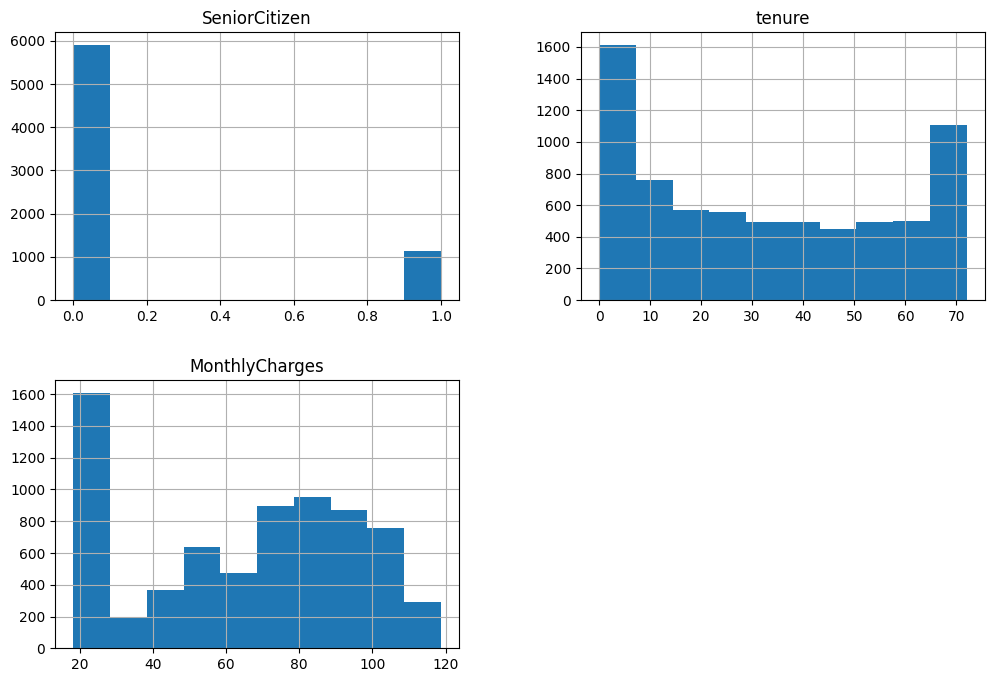

In [ ]:
import matplotlib.pyplot as plt
df.hist(figsize=(12,8))
plt.show()

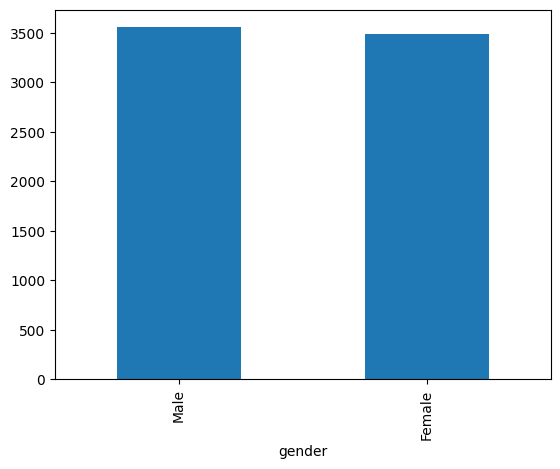

In [ ]:
df['gender'].value_counts().plot(kind='bar')
plt.show()

In [5]:
#fix total_chares

import numpy as np
df['TotalCharges'] = df['TotalCharges'].replace(" ", np.nan)
df['TotalCharges'] = df['TotalCharges'].astype(float)
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].mean())

In [6]:
#remove unwanted columns
X = df.drop(columns=['customerID', 'Churn'])
y = df['Churn'].map({'Yes': 1, 'No': 0})

In [13]:
# store numerical values and categorical values
numeric_features = X.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']

In [14]:
# encoding
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(handle_unknown='ignore')
X_cat = encoder.fit_transform(df[categorical_features]).toarray()
X_num = df[numeric_features].values

X_processed = np.hstack([X_num, X_cat])
y = df['Churn']


In [15]:
#test train split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42, stratify=y
)


In [16]:
#build decision tree
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=1, criterion='gini')
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=1)

In [17]:
# hyperparameter tuning
from sklearn.model_selection import GridSearchCV

dt_params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}

dt_model = DecisionTreeClassifier(random_state=42)

dt_grid = GridSearchCV(
    estimator=dt_model,
    param_grid=dt_params,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

dt_grid.fit(X_train, y_train)

print("Best Decision Tree Parameters:", dt_grid.best_params_)
print("Best Decision Tree CV Accuracy:", dt_grid.best_score_)

Best Decision Tree Parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 2}
Best Decision Tree CV Accuracy: 0.7921500517729682


In [18]:
#train
best_dt = dt_grid.best_estimator_
best_dt.fit(X_train, y_train)


DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=10,
                       random_state=42)

In [19]:
#evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred_dt = best_dt.predict(X_test)

print("\nDecision Tree Test Accuracy:", accuracy_score(y_test, y_pred_dt))
print("\nDecision Tree Classification Report:\n", classification_report(y_test, y_pred_dt))
print("\nDecision Tree Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))



Decision Tree Test Accuracy: 0.7984386089425124

Decision Tree Classification Report:
               precision    recall  f1-score   support

          No       0.85      0.88      0.87      1035
         Yes       0.63      0.57      0.60       374

    accuracy                           0.80      1409
   macro avg       0.74      0.72      0.73      1409
weighted avg       0.79      0.80      0.79      1409


Decision Tree Confusion Matrix:
 [[913 122]
 [162 212]]


In [20]:
from sklearn.neural_network import MLPClassifier


In [21]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [22]:
from sklearn.neural_network import MLPClassifier

nn_model = MLPClassifier(
    hidden_layer_sizes=(50, ),   # 1 hidden layer with 50 neurons
    activation='relu',           # activation function
    solver='adam',               # optimizer
    learning_rate_init=0.001,    # learning rate
    max_iter=300,                # number of epochs
    random_state=42
)

In [ ]:
from sklearn.neural_network import MLPClassifier

nn_params = {
    'hidden_layer_sizes': [(50,), (100,), (50,50)],
    'learning_rate_init': [0.001, 0.01],
    'alpha': [0.0001, 0.001, 0.01],   # L2 Regularization
    'solver': ['adam', 'sgd']
}

nn_model = MLPClassifier(max_iter=300, random_state=42)

nn_grid = GridSearchCV(
    estimator=nn_model,
    param_grid=nn_params,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

nn_grid.fit(X_train_scaled, y_train)

print("\nBest Neural Network Parameters:", nn_grid.best_params_)
print("Best Neural Network CV Accuracy:", nn_grid.best_score_)


In [24]:
best_nn = nn_grid.best_estimator_
best_nn.fit(X_train_scaled, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(alpha=0.001, hidden_layer_sizes=(50, 50), max_iter=300,
              random_state=42, solver='sgd')

In [25]:
# make predictions
y_pred_nn = best_nn.predict(X_test_scaled)

print("\nNeural Network Test Accuracy:", accuracy_score(y_test, y_pred_nn))
print("\nNeural Network Classification Report:\n", classification_report(y_test, y_pred_nn))
print("\nNeural Network Confusion Matrix:\n", confusion_matrix(y_test, y_pred_nn))




Neural Network Test Accuracy: 0.7821149751596878

Neural Network Classification Report:
               precision    recall  f1-score   support

          No       0.83      0.88      0.86      1035
         Yes       0.61      0.51      0.55       374

    accuracy                           0.78      1409
   macro avg       0.72      0.70      0.71      1409
weighted avg       0.77      0.78      0.78      1409


Neural Network Confusion Matrix:
 [[911 124]
 [183 191]]
